# Spatial Similarity Analysis with UNI Embeddings

This notebook analyzes how well UNI embeddings represent spatially neighboring patches.
For a selected patient, we:
1. Extract patch coordinates from embedding names
2. Calculate embedding similarity between spatial neighbors
3. Create heatmaps showing average neighbor similarity


In [2]:
!pip install matplotlib

  Using cached matplotlib-3.10.7-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB)
  Using cached contourpy-1.3.3-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.60.1-cp312-cp312-manylinux1_x86_64.manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_5_x86_64.whl.metadata (112 kB)
  Using cached kiwisolver-1.4.9-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (6.3 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.7-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (8.7 MB)
Using cached contourpy-1.3.3-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (362 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.60.1-cp312-cp312-manylinux1_x86_64.manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_5_x86_64.whl (4.9 MB)
Using ca

In [4]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [7]:
!pip install -U scikit-learn

  Using cached scikit_learn-1.7.2-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB)
  Using cached scipy-1.16.3-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (62 kB)
  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.7.2-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (9.5 MB)
Using cached joblib-1.5.2-py3-none-any.whl (308 kB)
Using cached scipy-1.16.3-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (35.7 MB)
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)


In [8]:
import numpy as np
import pandas as pd
import h5py
import faiss
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize


In [9]:
# Load metadata
metadata_df = pd.read_parquet("../metadata/patch_metadata.parquet")
print(f"Total patches: {len(metadata_df)}")
print(f"\nFirst few rows:")
print(metadata_df.head())


Total patches: 2036270

First few rows:
   faiss_index                                           slide_id  \
0            0  TCGA-5M-AAT6-01Z-00-DX1.8834C952-14E3-4491-815...   
1            1  TCGA-5M-AAT6-01Z-00-DX1.8834C952-14E3-4491-815...   
2            2  TCGA-5M-AAT6-01Z-00-DX1.8834C952-14E3-4491-815...   
3            3  TCGA-5M-AAT6-01Z-00-DX1.8834C952-14E3-4491-815...   
4            4  TCGA-5M-AAT6-01Z-00-DX1.8834C952-14E3-4491-815...   

   patch_coord_x  patch_coord_y                    slide  \
0         100372          12166  TCGA-5M-AAT6-01Z-00-DX1   
1         100372          13180  TCGA-5M-AAT6-01Z-00-DX1   
2         100372          14194  TCGA-5M-AAT6-01Z-00-DX1   
3         100372          15207  TCGA-5M-AAT6-01Z-00-DX1   
4         100372          16221  TCGA-5M-AAT6-01Z-00-DX1   

                               patch_filename    patient_id  
0  TCGA-5M-AAT6-01Z-00-DX1_(100372,12166).jpg  TCGA-5M-AAT6  
1  TCGA-5M-AAT6-01Z-00-DX1_(100372,13180).jpg  TCGA-5M-AAT6 

In [11]:
# Extract coordinates from embedding names
def extract_coordinates(embedding_name):
    """
    Extract (x, y) coordinates from embedding name.
    Example: 'TCGA-5M-AAT6-01Z-00-DX1_(100372,12166)' -> (100372, 12166)
    """
    match = re.search(r'\(([0-9]+),([0-9]+)\)', embedding_name)
    if match:
        return int(match.group(1)), int(match.group(2))
    return None, None

# Add coordinate columns
metadata_df[['coord_x', 'coord_y']] = metadata_df['patch_filename'].apply(
    lambda x: pd.Series(extract_coordinates(x))
)

print("\nMetadata with coordinates:")
print(metadata_df.head())



Metadata with coordinates:
   faiss_index                                           slide_id  \
0            0  TCGA-5M-AAT6-01Z-00-DX1.8834C952-14E3-4491-815...   
1            1  TCGA-5M-AAT6-01Z-00-DX1.8834C952-14E3-4491-815...   
2            2  TCGA-5M-AAT6-01Z-00-DX1.8834C952-14E3-4491-815...   
3            3  TCGA-5M-AAT6-01Z-00-DX1.8834C952-14E3-4491-815...   
4            4  TCGA-5M-AAT6-01Z-00-DX1.8834C952-14E3-4491-815...   

   patch_coord_x  patch_coord_y                    slide  \
0         100372          12166  TCGA-5M-AAT6-01Z-00-DX1   
1         100372          13180  TCGA-5M-AAT6-01Z-00-DX1   
2         100372          14194  TCGA-5M-AAT6-01Z-00-DX1   
3         100372          15207  TCGA-5M-AAT6-01Z-00-DX1   
4         100372          16221  TCGA-5M-AAT6-01Z-00-DX1   

                               patch_filename    patient_id  coord_x  coord_y  
0  TCGA-5M-AAT6-01Z-00-DX1_(100372,12166).jpg  TCGA-5M-AAT6   100372    12166  
1  TCGA-5M-AAT6-01Z-00-DX1_(100372,1

In [21]:
# Check number of patches per patient
patient_counts = metadata_df.groupby(['patient_id']).size().sort_values(ascending=False)
print("\nTop 10 patients by number of patches:")
print(patient_counts.head(10))



Top 10 patients by number of patches:
patient_id
TCGA-D7-5578    11851
TCGA-D7-6524    11417
TCGA-D7-6525     9112
TCGA-D7-5577     8837
TCGA-D7-6518     8624
TCGA-D7-6527     8595
TCGA-D7-8573     8548
TCGA-NH-A6GC     8232
TCGA-D7-8576     8085
TCGA-D7-6519     7691
dtype: int64


In [23]:
patient_counts

patient_id
TCGA-D7-5578    11851
TCGA-D7-6524    11417
TCGA-D7-6525     9112
TCGA-D7-5577     8837
TCGA-D7-6518     8624
                ...  
TCGA-AA-3854      158
TCGA-AA-3858      154
TCGA-MX-A663      148
TCGA-FP-A8CX      115
TCGA-R6-A6XG       87
Length: 749, dtype: int64

In [26]:
# Select a patient with reasonable number of patches (not too few, not too many)
# Let's take one with 2000-4000 patches for good coverage
selected_patient_idx = None
for idx, count in zip(patient_counts.index, patient_counts.values):
    print(idx, count)
    if 2000 <= count <= 4000:
        selected_patient_idx = idx
        break

if selected_patient_idx is None:
    # If no patient in that range, just take the first one
    selected_patient_idx = patient_counts.index[0]

selected_category = selected_patient_idx
print(f"\nSelected patient: {selected_patient_idx}")
print(f"Category: {selected_category}")
print(f"Number of patches: {patient_counts[selected_patient_idx]}")


TCGA-D7-5578 11851
TCGA-D7-6524 11417
TCGA-D7-6525 9112
TCGA-D7-5577 8837
TCGA-D7-6518 8624
TCGA-D7-6527 8595
TCGA-D7-8573 8548
TCGA-NH-A6GC 8232
TCGA-D7-8576 8085
TCGA-D7-6519 7691
TCGA-D7-6520 7553
TCGA-HU-A4H0 7447
TCGA-L5-A4OT 7271
TCGA-RD-A8MV 7151
TCGA-2H-A9GO 7115
TCGA-D7-6526 7017
TCGA-4N-A93T 6981
TCGA-D7-8579 6955
TCGA-2H-A9GF 6689
TCGA-CM-4744 6650
TCGA-RE-A7BO 6606
TCGA-CM-4746 6600
TCGA-HU-A4G2 6464
TCGA-RD-A8N9 6424
TCGA-5M-AAT5 6360
TCGA-D7-6528 6330
TCGA-CK-5915 6329
TCGA-RD-A7BS 6328
TCGA-L5-A4ON 6324
TCGA-5M-AAT4 6309
TCGA-CM-6674 6265
TCGA-CM-4743 6230
TCGA-D7-8578 6196
TCGA-JY-A6FB 6158
TCGA-CM-4750 6032
TCGA-RD-A8N0 6002
TCGA-KB-A6F7 5981
TCGA-CM-6675 5965
TCGA-G4-6298 5960
TCGA-L5-A4OP 5932
TCGA-G4-6304 5924
TCGA-D7-6818 5919
TCGA-SS-A7HO 5833
TCGA-D5-6929 5819
TCGA-2H-A9GN 5817
TCGA-QG-A5Z1 5764
TCGA-DC-6155 5756
TCGA-DM-A1DB 5751
TCGA-CK-5916 5682
TCGA-D7-6815 5662
TCGA-L5-A4OI 5636
TCGA-HU-A4G6 5617
TCGA-D7-8574 5598
TCGA-AZ-5403 5567
TCGA-DC-6681 5483
TCGA-HU-

In [28]:
# Filter metadata for selected patient
patient_metadata = metadata_df[
    (metadata_df['patient_id'] == selected_patient_idx)
].copy()

print(f"\nPatient has {len(patient_metadata)} patches")
print(f"Coordinate range:")
print(f"  X: {patient_metadata['coord_x'].min()} - {patient_metadata['coord_x'].max()}")
print(f"  Y: {patient_metadata['coord_y'].min()} - {patient_metadata['coord_y'].max()}")



Patient has 3999 patches
Coordinate range:
  X: 1015 - 104634
  Y: 0 - 76190


In [36]:
# Load embeddings for the selected patient
print("Loading embeddings from HDF5...")
print(f"Looking for patient: {selected_patient_idx}")

patient_embeddings = []
embedding_indices = []

# Create embedding names from patch filenames
# Format: "TCGA-5M-AAT6-01Z-00-DX1_(100372,12166)"
patient_metadata['embedding_name'] = patient_metadata.apply(
    lambda row: f"{row['slide']}_({row['coord_x']},{row['coord_y']})", 
    axis=1
)

print(f"Example embedding names:")
print(patient_metadata['embedding_name'].head())

# Load embeddings from HDF5
# Structure: HDF5[category][patient_uuid][embedding_name]
# We need to find the right category and patient UUID
with h5py.File("index_creation/features_uni2h.hdf5", "r") as f:
    found = False
    print(f"\nSearching for patient embeddings in HDF5...")
    
    # Check each category
    for category in f.keys():
        category_group = f[category]
        # Check each patient UUID in this category
        for patient_uuid in category_group.keys():
            patient_group = category_group[patient_uuid]
            # Check if any of our embedding names exist in this patient group
            first_embedding_name = patient_metadata['embedding_name'].iloc[0]
            if first_embedding_name in patient_group:
                print(f"Found patient in category: {category}")
                print(f"Patient UUID: {patient_uuid}")
                found = True
                
                # Load all embeddings for this patient
                for idx, row in tqdm(patient_metadata.iterrows(), total=len(patient_metadata)):
                    embedding_name = row['embedding_name']
                    if embedding_name in patient_group:
                        embedding_data = patient_group[embedding_name][()]
                        patient_embeddings.append(embedding_data)
                        embedding_indices.append(row['faiss_index'])
                    else:
                        print(f"Warning: {embedding_name} not found in HDF5")
                break
        if found:
            break
    
    if not found:
        raise ValueError(f"Could not find embeddings for patient {selected_patient_idx} in HDF5 file")

patient_embeddings = np.array(patient_embeddings)
print(f"\nLoaded embeddings shape: {patient_embeddings.shape}")
print(f"Expected shape: ({len(patient_metadata)}, 1536)")

# Normalize embeddings for cosine similarity
patient_embeddings_norm = normalize(patient_embeddings, norm='l2')
print("Embeddings normalized for cosine similarity")


Loading embeddings from HDF5...
Looking for patient: TCGA-AZ-6605
Example embedding names:
532963    TCGA-AZ-6605-01Z-00-DX1_(100571,11174)
532964    TCGA-AZ-6605-01Z-00-DX1_(100571,12190)
532965    TCGA-AZ-6605-01Z-00-DX1_(100571,13206)
532966    TCGA-AZ-6605-01Z-00-DX1_(100571,14222)
532967    TCGA-AZ-6605-01Z-00-DX1_(100571,15238)
Name: embedding_name, dtype: object

Searching for patient embeddings in HDF5...
Found patient in category: MSS
Patient UUID: TCGA-AZ-6605-01Z-00-DX1.4d634c3e-a1c0-42e1-a4d6-5980eddfa0ca


100%|██████████| 3999/3999 [00:02<00:00, 1796.14it/s]


Loaded embeddings shape: (3999, 1536)
Expected shape: (3999, 1536)
Embeddings normalized for cosine similarity


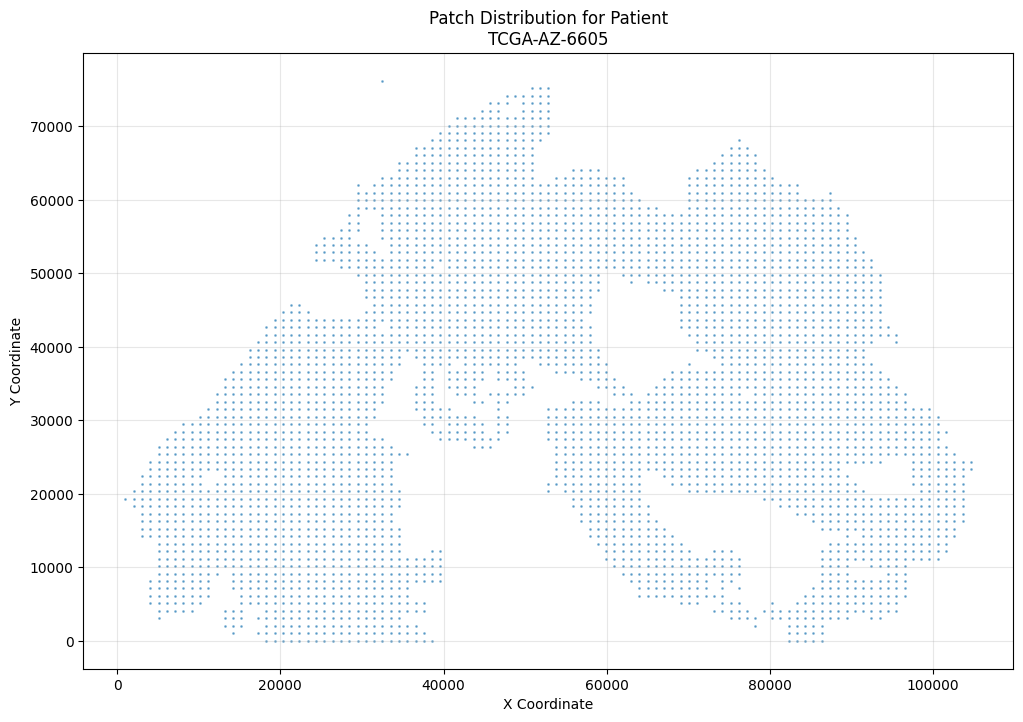

In [37]:
# Visualize patch distribution
plt.figure(figsize=(12, 8))
plt.scatter(patient_metadata['coord_x'], patient_metadata['coord_y'], 
            alpha=0.5, s=1)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title(f'Patch Distribution for Patient\n{selected_patient_idx}')
plt.grid(True, alpha=0.3)
plt.show()


In [38]:
# Calculate average similarity with spatial neighbors
def get_spatial_neighbors(x, y, coords_df, radius=1000):
    """
    Find patches within spatial radius of (x, y).
    radius is in coordinate units (pixels).
    """
    distances = np.sqrt(
        (coords_df['coord_x'] - x)**2 + 
        (coords_df['coord_y'] - y)**2
    )
    neighbors = coords_df[distances <= radius].index.tolist()
    return neighbors

print("Calculating neighbor similarities...")
print("This may take a few minutes...")

# Store similarity scores
avg_similarities = []
neighbor_counts = []

# Reset index for easier access
patient_metadata_reset = patient_metadata.reset_index(drop=True)

for idx in tqdm(range(len(patient_metadata_reset))):
    row = patient_metadata_reset.iloc[idx]
    x, y = row['coord_x'], row['coord_y']
    
    # Get spatial neighbors
    neighbor_indices = get_spatial_neighbors(x, y, patient_metadata_reset, radius=1500)
    
    # Remove self
    neighbor_indices = [i for i in neighbor_indices if i != idx]
    
    if len(neighbor_indices) > 0:
        # Calculate cosine similarity with all neighbors
        current_embedding = patient_embeddings_norm[idx:idx+1]
        neighbor_embeddings = patient_embeddings_norm[neighbor_indices]
        
        similarities = cosine_similarity(current_embedding, neighbor_embeddings)[0]
        avg_sim = np.mean(similarities)
    else:
        avg_sim = np.nan
    
    avg_similarities.append(avg_sim)
    neighbor_counts.append(len(neighbor_indices))

patient_metadata_reset['avg_neighbor_similarity'] = avg_similarities
patient_metadata_reset['neighbor_count'] = neighbor_counts

print("\nSummary statistics:")
print(patient_metadata_reset[['avg_neighbor_similarity', 'neighbor_count']].describe())


Calculating neighbor similarities...
This may take a few minutes...


100%|██████████| 3999/3999 [00:05<00:00, 743.62it/s]


Summary statistics:
       avg_neighbor_similarity  neighbor_count
count              3998.000000     3999.000000
mean                  0.667049        7.429857
std                   0.097106        1.192153
min                   0.331579        0.000000
25%                   0.595043        8.000000
50%                   0.674303        8.000000
75%                   0.741680        8.000000
max                   0.902177        8.000000


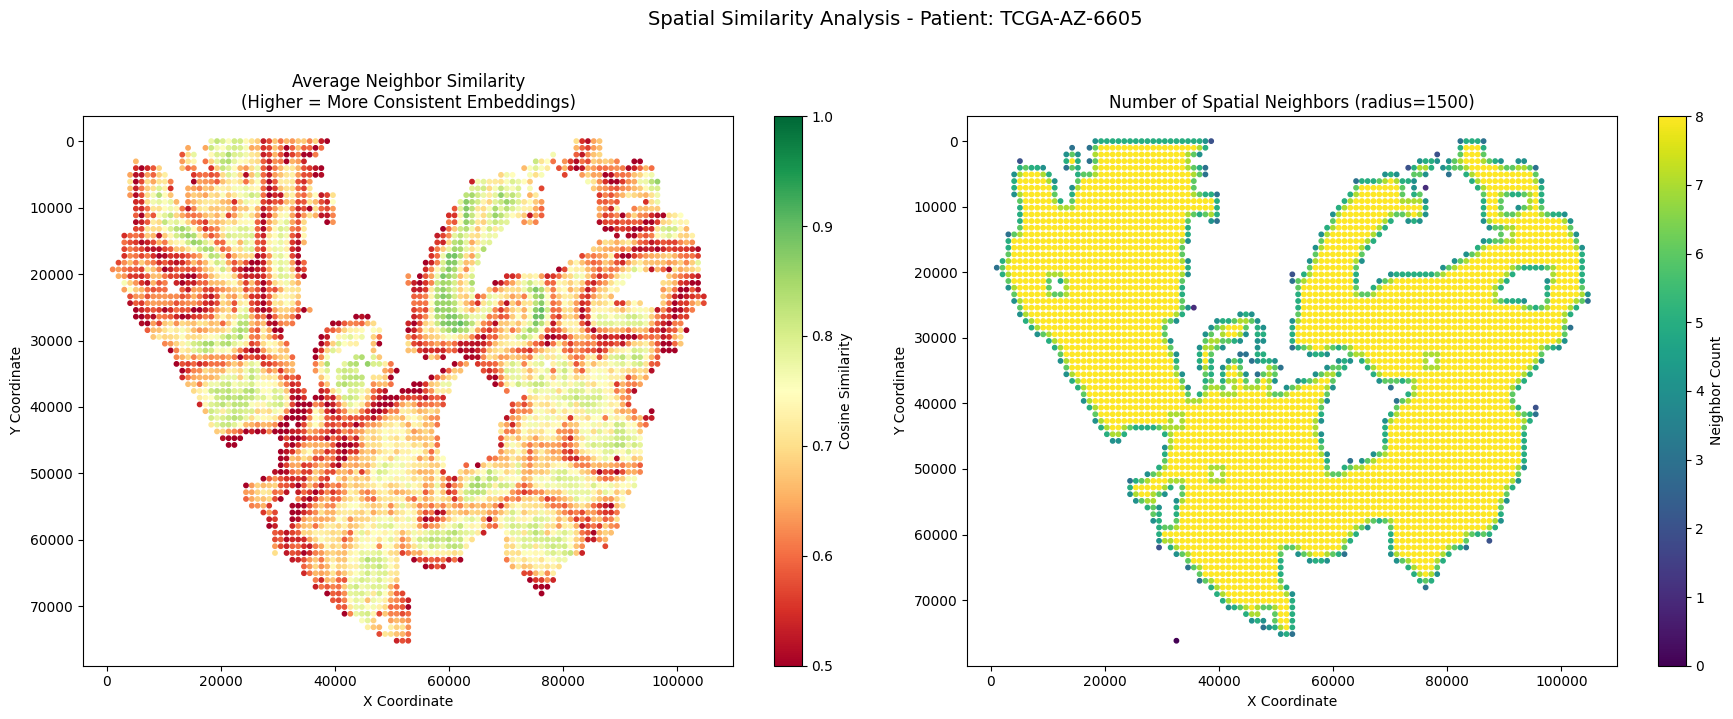

In [40]:
# Create heatmap of average neighbor similarity
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Plot 1: Scatter plot colored by similarity
scatter = axes[0].scatter(
    patient_metadata_reset['coord_x'], 
    patient_metadata_reset['coord_y'],
    c=patient_metadata_reset['avg_neighbor_similarity'],
    cmap='RdYlGn',
    s=10,
    vmin=0.5,
    vmax=1.0
)
axes[0].set_xlabel('X Coordinate')
axes[0].set_ylabel('Y Coordinate')
axes[0].set_title('Average Neighbor Similarity\n(Higher = More Consistent Embeddings)')
plt.colorbar(scatter, ax=axes[0], label='Cosine Similarity')
axes[0].invert_yaxis()  # Invert Y to match image coordinates

# Plot 2: Number of neighbors
scatter2 = axes[1].scatter(
    patient_metadata_reset['coord_x'], 
    patient_metadata_reset['coord_y'],
    c=patient_metadata_reset['neighbor_count'],
    cmap='viridis',
    s=10
)
axes[1].set_xlabel('X Coordinate')
axes[1].set_ylabel('Y Coordinate')
axes[1].set_title('Number of Spatial Neighbors (radius=1500)')
plt.colorbar(scatter2, ax=axes[1], label='Neighbor Count')
axes[1].invert_yaxis()

plt.suptitle(f'Spatial Similarity Analysis - Patient: {selected_patient_idx}', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


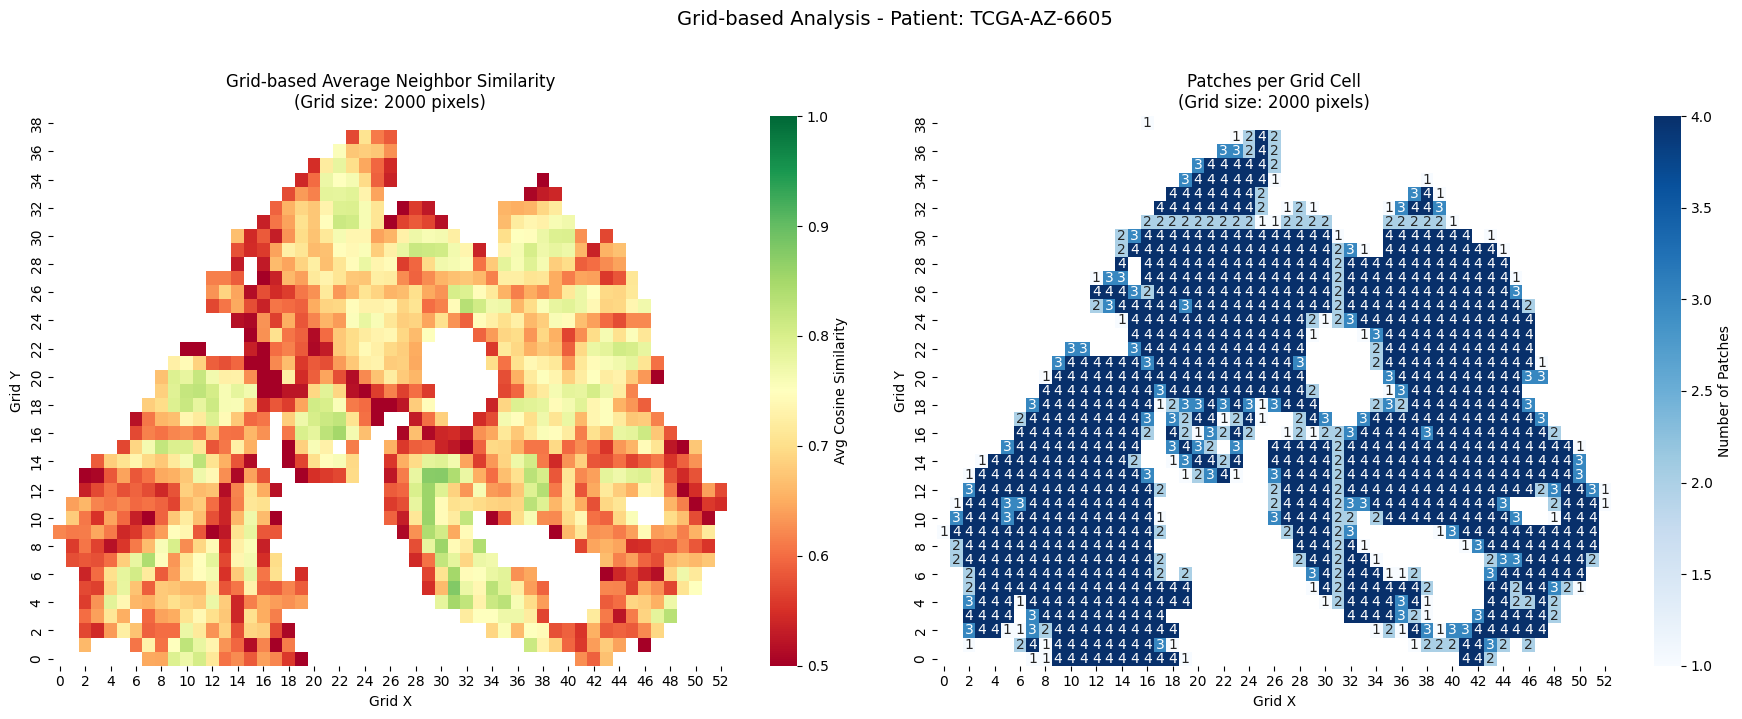

In [42]:
# Create a grid-based heatmap for smoother visualization
# Bin coordinates into grid
grid_size = 2000  # pixels per grid cell

patient_metadata_reset['grid_x'] = (patient_metadata_reset['coord_x'] // grid_size).astype(int)
patient_metadata_reset['grid_y'] = (patient_metadata_reset['coord_y'] // grid_size).astype(int)

# Calculate average similarity per grid cell
grid_stats = patient_metadata_reset.groupby(['grid_x', 'grid_y']).agg({
    'avg_neighbor_similarity': 'mean',
    'neighbor_count': 'mean',
    'faiss_index': 'count'  # Use an existing column to count patches
}).reset_index()

grid_stats.columns = ['grid_x', 'grid_y', 'avg_similarity', 'avg_neighbors', 'patch_count']

# Create pivot tables for heatmap
similarity_pivot = grid_stats.pivot(index='grid_y', columns='grid_x', values='avg_similarity')
count_pivot = grid_stats.pivot(index='grid_y', columns='grid_x', values='patch_count')

# Plot grid-based heatmaps
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Similarity heatmap
sns.heatmap(similarity_pivot, ax=axes[0], cmap='RdYlGn', 
            cbar_kws={'label': 'Avg Cosine Similarity'},
            vmin=0.5, vmax=1.0)
axes[0].set_title(f'Grid-based Average Neighbor Similarity\n(Grid size: {grid_size} pixels)')
axes[0].set_xlabel('Grid X')
axes[0].set_ylabel('Grid Y')
axes[0].invert_yaxis()

# Patch count heatmap
sns.heatmap(count_pivot, ax=axes[1], cmap='Blues',
            cbar_kws={'label': 'Number of Patches'},
            annot=True, fmt='.0f')
axes[1].set_title(f'Patches per Grid Cell\n(Grid size: {grid_size} pixels)')
axes[1].set_xlabel('Grid X')
axes[1].set_ylabel('Grid Y')
axes[1].invert_yaxis()

plt.suptitle(f'Grid-based Analysis - Patient: {selected_patient_idx}', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


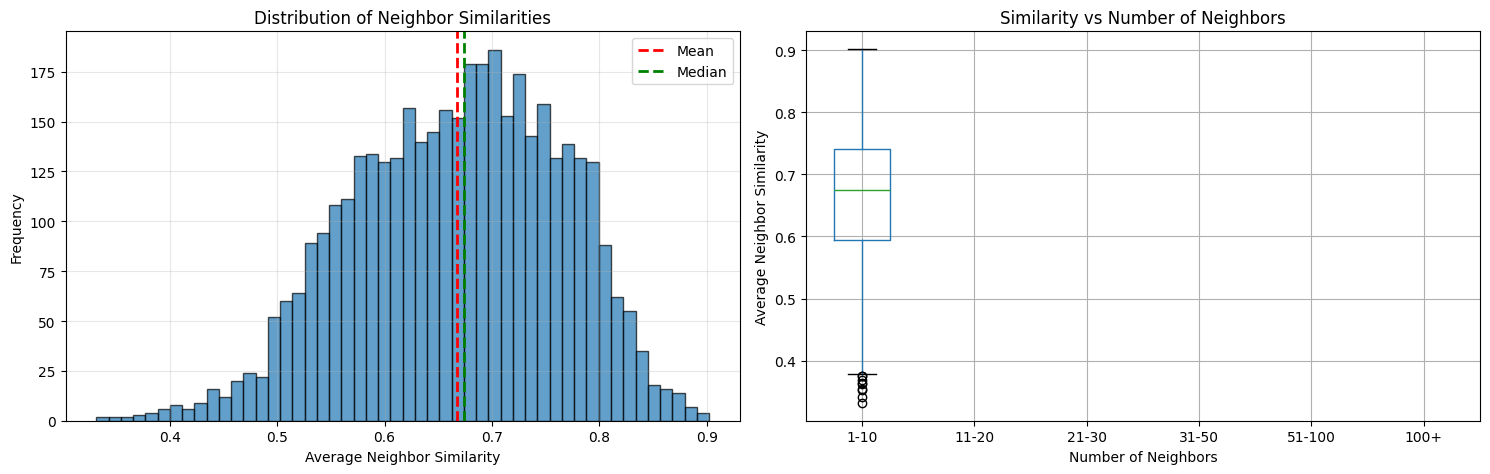

In [43]:
# Distribution analysis
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram of similarities
axes[0].hist(patient_metadata_reset['avg_neighbor_similarity'].dropna(), 
             bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(patient_metadata_reset['avg_neighbor_similarity'].mean(), 
                color='red', linestyle='--', linewidth=2, label='Mean')
axes[0].axvline(patient_metadata_reset['avg_neighbor_similarity'].median(), 
                color='green', linestyle='--', linewidth=2, label='Median')
axes[0].set_xlabel('Average Neighbor Similarity')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Neighbor Similarities')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Boxplot by number of neighbors
# Bin neighbor counts for better visualization
patient_metadata_reset['neighbor_bin'] = pd.cut(
    patient_metadata_reset['neighbor_count'], 
    bins=[0, 10, 20, 30, 50, 100, 1000],
    labels=['1-10', '11-20', '21-30', '31-50', '51-100', '100+']
)

patient_metadata_reset.boxplot(
    column='avg_neighbor_similarity', 
    by='neighbor_bin', 
    ax=axes[1]
)
axes[1].set_xlabel('Number of Neighbors')
axes[1].set_ylabel('Average Neighbor Similarity')
axes[1].set_title('Similarity vs Number of Neighbors')
axes[1].get_figure().suptitle('')  # Remove automatic title

plt.tight_layout()
plt.show()


In [44]:
# Summary statistics
print("=" * 60)
print("SUMMARY STATISTICS")
print("=" * 60)
print(f"\nPatient: {selected_patient_idx}")
print(f"Category: {selected_category}")
print(f"Total patches: {len(patient_metadata_reset)}")
print(f"\nAverage Neighbor Similarity:")
print(f"  Mean: {patient_metadata_reset['avg_neighbor_similarity'].mean():.4f}")
print(f"  Median: {patient_metadata_reset['avg_neighbor_similarity'].median():.4f}")
print(f"  Std: {patient_metadata_reset['avg_neighbor_similarity'].std():.4f}")
print(f"  Min: {patient_metadata_reset['avg_neighbor_similarity'].min():.4f}")
print(f"  Max: {patient_metadata_reset['avg_neighbor_similarity'].max():.4f}")
print(f"\nInterpretation:")
mean_sim = patient_metadata_reset['avg_neighbor_similarity'].mean()
if mean_sim > 0.85:
    print("  ✓ Excellent: UNI embeddings are very consistent for spatially close patches")
elif mean_sim > 0.75:
    print("  ✓ Good: UNI embeddings show good spatial consistency")
elif mean_sim > 0.65:
    print("  ~ Moderate: UNI embeddings show some spatial consistency")
else:
    print("  ✗ Low: UNI embeddings show weak spatial consistency")
print("=" * 60)


SUMMARY STATISTICS

Patient: TCGA-AZ-6605
Category: TCGA-AZ-6605
Total patches: 3999

Average Neighbor Similarity:
  Mean: 0.6670
  Median: 0.6743
  Std: 0.0971
  Min: 0.3316
  Max: 0.9022

Interpretation:
  ~ Moderate: UNI embeddings show some spatial consistency


In [ ]:
# Optional: Save results
output_file = f"spatial_similarity_results_{selected_patient_idx.split('.')[0]}.csv"
patient_metadata_reset.to_csv(output_file, index=False)
print(f"\nResults saved to: {output_file}")




Results saved to: spatial_similarity_results_TCGA-AZ-6605.csv
cp: cannot create regular file '/content/drive/MyDrive/': No such file or directory
Copied to Google Drive
